In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import plot.viz_sequence as viz_sequence
import pyBigWig
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import json
import tqdm
import h5py
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
model_type = "profile"

In [3]:
# Shared paths/constants
raw_data_base_path = "/users/amtseng/att_priors/data/raw/"
proc_data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
tfm_results_path = "/users/amtseng/att_priors/results/tfmodisco/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [4]:
# BPNet
condition_name = "BPNet"
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(proc_data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
if model_type == "profile":
    controls = "shared"
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor

bpnet_tasks = ["Nanog", "Oct4", "Sox2"]
task_index = 0
footprints_path = os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_peaks-idr.bed.gz" % bpnet_tasks[task_index].upper())
pos_bigwig = os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_pos.bw" % bpnet_tasks[task_index].upper())
neg_bigwig = os.path.join(raw_data_base_path, "BPNet_ChIPnexus/BPNet_%s_neg.bw" % bpnet_tasks[task_index].upper())
noprior_model_path = os.path.join(model_base_path, "BPNet/15/model_ckpt_epoch_17.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/7/model_ckpt_epoch_18.pt")
noprior_tfm_path = os.path.join(tfm_results_path, "BPNet/BPNet_r15_e17_task%d_tfm.h5" % task_index)
prior_tfm_path = os.path.join(tfm_results_path, "BPNet/BPNet_prior_r7_e18_task%d_tfm.h5" % task_index)

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [6]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [7]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Import ChIP-nexus peaks
For BPNet, these can act as an easy proxy for footprints, althought they are very wide footprints

In [8]:
footprints = pd.read_csv(
    footprints_path, sep="\t", header=None,
    names=[
        "chrom", "peak_start", "peak_end", "name", "score", "strand",
        "signal", "pval", "qval", "summit_offset"
    ]
)
footprints = footprints[footprints["chrom"].isin(chrom_set)]

### Create reader for BigWigs
Only for something like BPNet, which has ChIP-nexus profiles, which offer a "continuous" view of footprint confidence, rather than a simple binary footprint classification

In [9]:
def get_profiles(chrom, start, end):
    """
    Returns N-array of BigWig values, as sum of negative and positive strands.
    """
    result = np.empty((end - start, 2))
    with pyBigWig.open(neg_bigwig, "r") as f:
        result[:, 0] = f.values(chrom, start, end)
    with pyBigWig.open(pos_bigwig, "r") as f:
        result[:, 1] = f.values(chrom, start, end)
    return np.sum(np.nan_to_num(result), axis=1)

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model

In [10]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_set = data_loading.get_positive_profile_coords(
        files_spec_path, task_ind=task_index, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_set = data_loading.get_positive_binary_bins(
        files_spec_path, task_ind=task_index, chrom_set=chrom_set
    )

### Compute importances

In [11]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [12]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls,
            task_index=task_index
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length, task_index=task_index
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(batch)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [13]:
num_samples = 1000
rng = np.random.RandomState(20200318)
sample = pos_set[rng.choice(len(pos_set), size=num_samples, replace=False)]

In [14]:
# Get coordinates for the sample
if model_type == "profile":
    # For profile models, add a random jitter to avoid center-bias
    jitters = np.random.randint(-128, 128 + 1, size=len(sample))
    sample[:, 1] = sample[:, 1] + jitters
    sample[:, 2] = sample[:, 2] + jitters
    sample_coords = sample
else:
    sample_coords = input_func(sample)[2]

In [15]:
# Compute the importance scores and 1-hot seqs
imp_type = ("SHAP scores", "input gradients")[0]
imp_func = compute_shap_scores if imp_type == "SHAP scores" else compute_gradients
noprior_imp_scores, sample_input_seqs = imp_func(
    noprior_model, sample
)
prior_imp_scores, _ = imp_func(
    prior_model, sample
)

In [16]:
# Pad the coordinates on both sides symmetrically to make them `input_length` 
centers = (sample_coords[:, 1] + sample_coords[:, 2]) // 2
starts = centers - (input_length // 2)
ends = starts + input_length
sample_coords[:, 1] = starts
sample_coords[:, 2] = ends

284 ['chr1' 14002114 14003460]
Without priors:


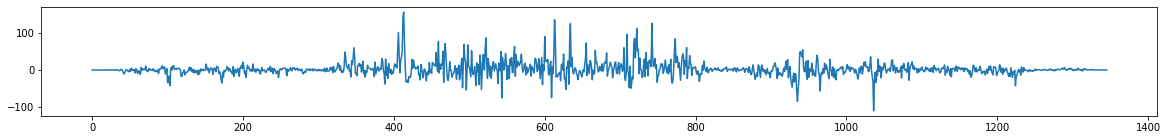

With priors:


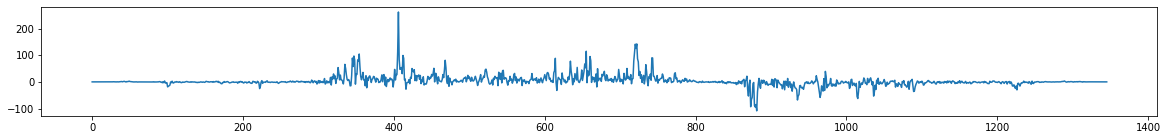

434 ['chr1' 133660238 133661584]
Without priors:


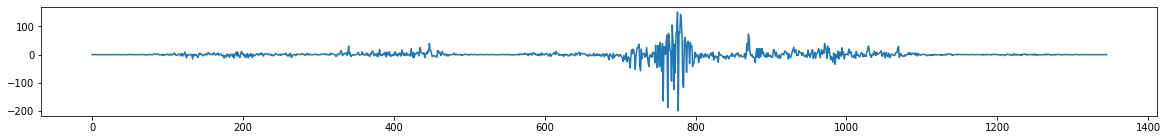

With priors:


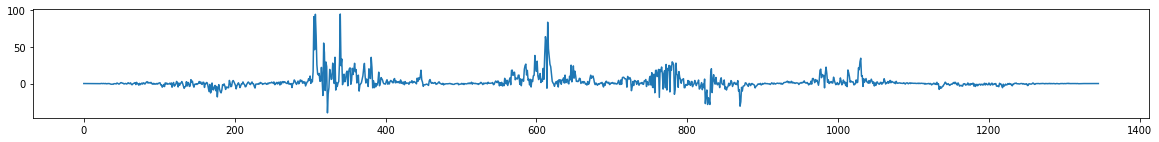

337 ['chr1' 76028596 76029942]
Without priors:


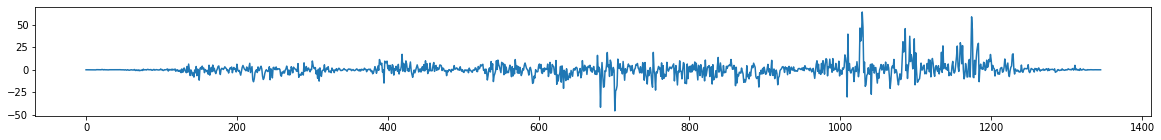

With priors:


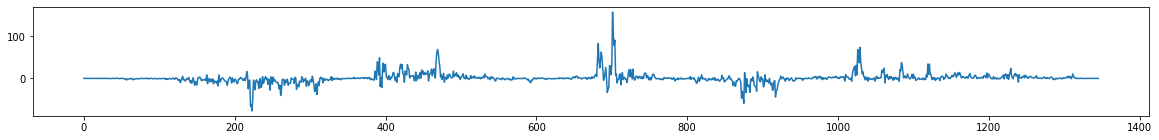

In [17]:
# Plot out a few examples
for i in np.random.choice(num_samples, size=3, replace=False):
    print(i, sample[i])
    print("=========================")
    print("Without priors:")
    plt.figure(figsize=(20, 2))
    plt.plot(np.sum(noprior_imp_scores[i] * sample_input_seqs[i], axis=1))
    plt.show()
    print("With priors:")
    plt.figure(figsize=(20, 2))
    plt.plot(np.sum(prior_imp_scores[i] * sample_input_seqs[i], axis=1))
    plt.show()

### Quantify agreement of importances with footprints using overlap
In each importance score track (over the entire input region), do the importances tend to be elevated more in known footprints?

In [18]:
def compute_footprint_overlap_amount(coords, score_tracks, footprints):
    """
    From an N x 3 object array of coordinates, a parallel N x I x 4 array
    of score tracks, and a table of imported footprints, this function computes
    and returns the overlap amount for each of the N examples, where the overlap
    for an example is the fraction of score magnitudes in its track that fall
    within a footprint. An overlap will be NaN if there are no footprints in the
    coordinate. Returns an N-array.
    """
    score_tracks = np.abs(score_tracks)  # Take absolute value of score tracks
    overlaps = np.empty(len(coords))
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        # Filter down the set of footprints to only those that overlap with the
        # coordinate
        fps = footprints[
            (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
            (start <= footprints["peak_end"])
        ]
        mask = np.zeros(end - start, dtype=bool)
        intervals = fps[["peak_start", "peak_end"]].values - start
        for interval in intervals:
            mask[interval[0]:interval[1]] = True
        if not np.sum(mask):
            overlaps[i] = np.nan
        else:
            overlaps[i] = np.sum(score_tracks[i][mask]) / np.sum(score_tracks[i])
    return overlaps

In [19]:
noprior_imp_fp_overlaps = compute_footprint_overlap_amount(
    sample_coords, noprior_imp_scores * sample_input_seqs, footprints
)
prior_imp_fp_overlaps = compute_footprint_overlap_amount(
    sample_coords, prior_imp_scores * sample_input_seqs, footprints
)

# Remove the NaNs, which is where no footprint was in the coordinate
noprior_imp_fp_overlaps = noprior_imp_fp_overlaps[np.isfinite(noprior_imp_fp_overlaps)]
prior_imp_fp_overlaps = prior_imp_fp_overlaps[np.isfinite(prior_imp_fp_overlaps)]

Average score without priors: 0.656241
Average score with priors: 0.723723
Test of difference of means: t = 18.694592, p = 0.000000


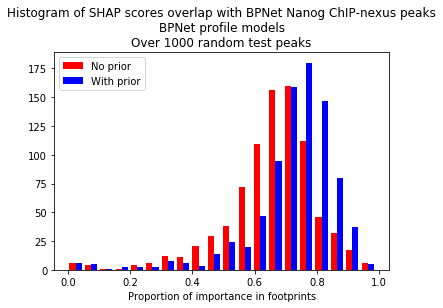

In [20]:
bin_num = 20
plt.figure()
plt.hist(
    [noprior_imp_fp_overlaps, prior_imp_fp_overlaps],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
if condition_name == "BPNet":
    title = "Histogram of %s overlap with BPNet %s ChIP-nexus peaks" % (imp_type, bpnet_tasks[task_index])
else:
    title = "Histogram of %s overlap with %s footprints" % (imp_type, condition_name)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
plt.title(title)
plt.xlabel("Proportion of importance in footprints")
plt.legend()
print("Average score without priors: %f" % np.nanmean(noprior_imp_fp_overlaps))
print("Average score with priors: %f" % np.nanmean(prior_imp_fp_overlaps))
t, p = scipy.stats.ttest_rel(prior_imp_fp_overlaps, noprior_imp_fp_overlaps)
print("Test of difference of means: t = %f, p = %f" % (t, p / 2))

### Retrieve the windows of highest importance

In [21]:
def get_high_importance_windows(coords, imp_scores, window_size=10, num_windows=10000):
    """
    From an N x 3 object array of coordinates and parallel N x I x 4 array
    of actual importance scores, this computes the windows with the highest
    importance scores based on total importance. Returns the `num_windows`
    best windows, as an M x 3 object array of window coordinates and a 
    parallel M-array of total importances.
    """
    assert np.all(coords[:, 2] - coords[:, 1] == input_length), \
        "Expect all coordinates to be of length %d" % input_length
    
    num_windows_per_coord = input_length - window_size + 1
    num_windows_total = num_windows_per_coord * len(coords)
    window_coords = np.empty((num_windows_total, 3), dtype=object)
    window_scores = np.empty(num_windows_total)
    
    # imp_scores = np.abs(imp_scores)  # Take absolute value
    imp_scores_pos = imp_scores.copy()
    imp_scores_pos[imp_scores_pos < 0] = 0
    
    next_index = 0  # Next index to fill in
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        imp_score_track = imp_scores_pos[i]
        for j in range(num_windows_per_coord):
            window_coords[next_index, 0] = chrom
            window_coords[next_index, 1] = start + j
            window_coords[next_index, 2] = start + j + window_size
            window_scores[next_index] = np.sum(imp_score_track[j:(j + window_size)])
            next_index += 1
    
    # Pick only the best windows
    inds = np.flip(np.argsort(window_scores))
    return window_coords[inds[:num_windows]], window_scores[inds[:num_windows]]

In [22]:
noprior_window_coords, noprior_window_scores = get_high_importance_windows(
    sample_coords, noprior_imp_scores * sample_input_seqs, window_size=10, num_windows=10000
)
prior_window_coords, prior_window_scores = get_high_importance_windows(
    sample_coords, prior_imp_scores * sample_input_seqs, window_size=10, num_windows=10000
)

### Quantify agreement of importance windows with footprints using ranks
Rank all of the windows by importance; do the windows at the top tend to overlap with footprints?

In [23]:
def compute_footprint_overlap(coords, footprints):
    """
    From an N x 3 object array of coordinates and a table of imported footprints,
    this function determines which coordinates overlap with a footprint.
    Returns a N-array binary mask, denoting which coordinates overlap with a
    footprint.
    """
    mask = np.zeros(len(coords), dtype=int)
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        fps = footprints[
            (footprints["chrom"] == chrom) & (footprints["peak_start"] <= end) & \
            (start <= footprints["peak_end"])
        ]
        if len(fps):
            mask[i] = 1
    return mask

In [24]:
noprior_window_overlap_mask = compute_footprint_overlap(
    noprior_window_coords, footprints
)
prior_window_overlap_mask = compute_footprint_overlap(
    prior_window_coords, footprints
)

In [25]:
def normed_rank_enrichment(ordered_mask):
    """
    From a binary mask array (in order from best to worst thresholds), computes
    the rank enrichment at each threshold. Specifically, this computes a
    normalized CDF of how many 1s are seen in the first k instances.
    """
    cdf = np.cumsum(ordered_mask)
    # To normalize, divide by the expectation if there all 1s were spread
    # out evenly across the instances
    expectation = np.sum(ordered_mask) / len(ordered_mask) * np.arange(1, len(cdf) + 1)
    return cdf / expectation

In [26]:
noprior_window_overlap_cdf = normed_rank_enrichment(noprior_window_overlap_mask)
prior_window_overlap_cdf = normed_rank_enrichment(prior_window_overlap_mask)

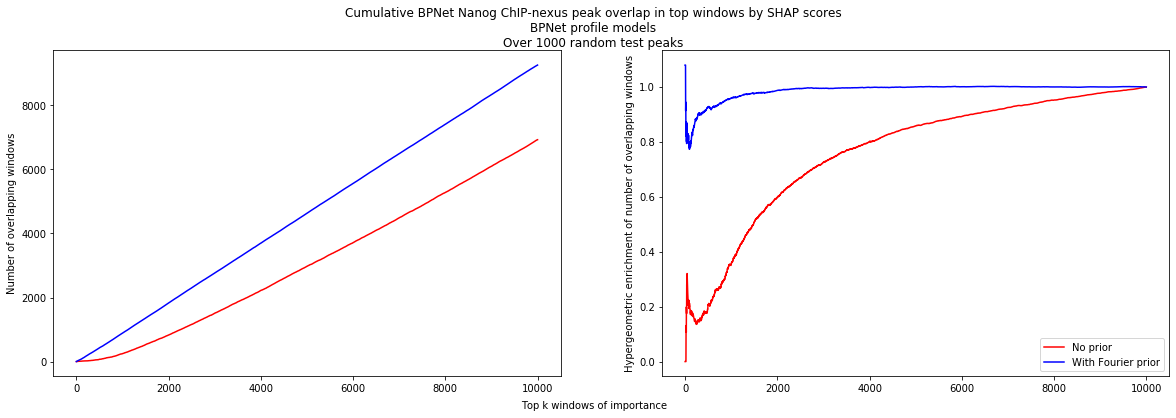

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
if condition_name == "BPNet":
    title = "Cumulative BPNet %s ChIP-nexus peak overlap in top windows by %s" % (bpnet_tasks[task_index], imp_type)
else:
    title = "Cumulative %s footprint overlap in top windows by %s" % (condition_name, imp_type)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
fig.suptitle(title)
ax[0].plot(np.cumsum(noprior_window_overlap_mask), label="No prior", color="red")
ax[0].plot(np.cumsum(prior_window_overlap_mask), label="With Fourier prior", color="blue")
ax[0].set_ylabel("Number of overlapping windows")
ax[1].plot(noprior_window_overlap_cdf, label="No prior", color="red")
ax[1].plot(prior_window_overlap_cdf, label="With Fourier prior", color="blue")
ax[1].set_ylabel("Hypergeometric enrichment of number of overlapping windows")
fig.text(0.45, 0.05, "Top k windows of importance")
plt.legend()

### Correlate importance windows with profile height
This can't be done if there are no ChIP-nexus profiles

In [28]:
def get_interval_profile_heights(coords, profile_func, flank_size=35):
    """
    Given an N x 3 object array of coordinates and a function that returns
    the profile given any coordinate (chrom, start, and end), computes the
    profile heights of each of the N coordinates. For each coordinate, this
    will look `flank_size` base pairs left and right of the center, and
    record the total profile heights seen. Returns an N-array of profile
    height sums.
    """
    heights = np.empty(len(coords))
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        center = (start + end) // 2
        heights[i] = np.sum(
            profile_func(chrom, center - flank_size, center + flank_size)
        )
    return heights

In [29]:
noprior_window_prof_heights = get_interval_profile_heights(noprior_window_coords, get_profiles)
prior_window_prof_heights = get_interval_profile_heights(prior_window_coords, get_profiles)

In [30]:
print("Correlation of top importance windows with profile height")
noprior_window_prof_height_corr = scipy.stats.spearmanr(noprior_window_scores, noprior_window_prof_heights)[0]
prior_window_prof_height_corr = scipy.stats.spearmanr(prior_window_scores, prior_window_prof_heights)[0]
print("No priors: %f" % noprior_window_prof_height_corr)
print("With priors: %f" % prior_window_prof_height_corr)

Correlation of top importance windows with profile height
No priors: -0.282996
With priors: 0.052074


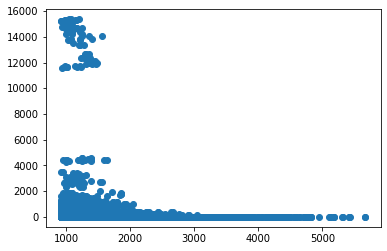

In [31]:
plt.figure()
plt.scatter(noprior_window_scores, noprior_window_prof_heights)

### Quantify agreement of importance windows with profile-derived footprints using ranks
Rank all of the windows by importance; do the windows at the top tend to overlap with footprints? Instead of using pre-determined footprints, we use profile heights to binarize footprint classification

In [32]:
def binarize_footprints_by_profiles(coords, profile_func, flank_size=35, quant_cutoff=0.9):
    """
    Given an N x 3 object array of coordinates and a function that returns
    the profile given any coordinate (chrom, start, and end), determines
    which of the N coordinates overlie a footprint, based on profile counts.
    For each coordinate, this will look `flank_size` base pairs left and right
    of the center, and record the maximum profile height seen. A coordinate is
    deemed to overlie a footprint if its maximum profile height is in the
    `quant_cutoff` percentile (default 90th percentile) over all given
    coordinates. Returns an N-array as a binary mask of which centers overlie a
    footprint.
    """
    heights = np.empty(len(coords))
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        center = (start + end) // 2
        heights[i] = np.max(
            profile_func(chrom, center - flank_size, center + flank_size)
        )
    inds = np.flip(np.argsort(heights))  # Best (highest) height first
    num_keep = int(quant_cutoff * len(coords))
    mask = np.zeros(len(coords), dtype=int)
    mask[inds[:num_keep]] = 1
    return mask

In [33]:
noprior_window_profoverlap_mask = binarize_footprints_by_profiles(
    noprior_window_coords, get_profiles
)
prior_window_profoverlap_mask = binarize_footprints_by_profiles(
    prior_window_coords, get_profiles
)

In [35]:
noprior_window_profoverlap_cdf = normed_rank_enrichment(noprior_window_profoverlap_mask)
prior_window_profoverlap_cdf = normed_rank_enrichment(prior_window_profoverlap_mask)

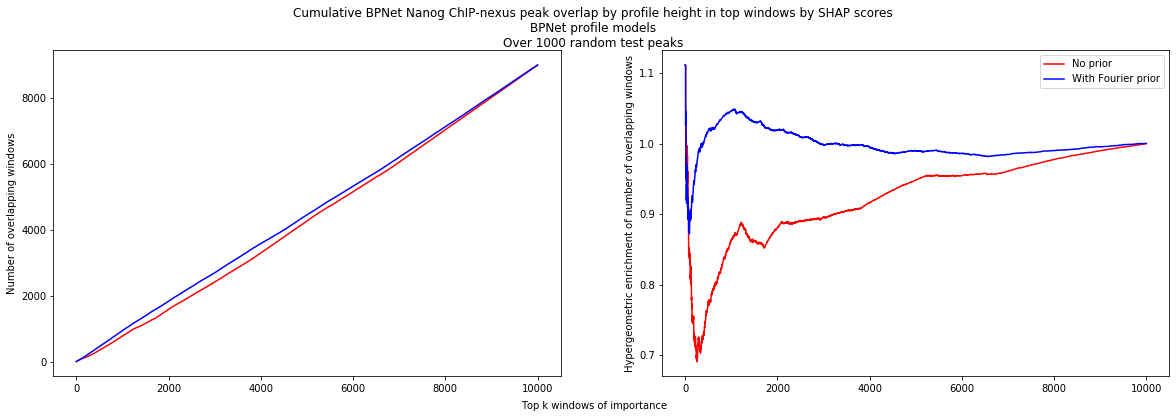

In [36]:
assert condition_name == "BPNet"
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
title = "Cumulative BPNet %s ChIP-nexus peak overlap by profile height in top windows by %s" % (bpnet_tasks[task_index], imp_type)
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
fig.suptitle(title)
ax[0].plot(np.cumsum(noprior_window_profoverlap_mask), label="No prior", color="red")
ax[0].plot(np.cumsum(prior_window_profoverlap_mask), label="With Fourier prior", color="blue")
ax[0].set_ylabel("Number of overlapping windows")
ax[1].plot(noprior_window_profoverlap_cdf, label="No prior", color="red")
ax[1].plot(prior_window_profoverlap_cdf, label="With Fourier prior", color="blue")
ax[1].set_ylabel("Hypergeometric enrichment of number of overlapping windows")
fig.text(0.45, 0.05, "Top k windows of importance")
plt.legend()

### Import the TF-MoDISco results

In [37]:
background_freqs = np.array([0.27, 0.23, 0.23, 0.27])
def info_content(track, pseudocount=0.001):
    """
    Given an L x 4 track, computes information content for each base and
    returns it as an L-array.
    """
    num_bases = track.shape[1]
    # Normalize track to probabilities along base axis
    track_norm = (track + pseudocount) / (np.sum(track, axis=1, keepdims=True) + (num_bases * pseudocount))
    ic = track_norm * np.log2(track_norm / np.expand_dims(background_freqs, axis=0))
    return np.sum(ic, axis=1)

In [38]:
def revcomp_motif(motif):
    return np.flip(motif, axis=(0, 1))

In [39]:
def import_tfmodisco_motifs(
    tfm_results_hdf5, min_seqlets=750, min_ic=0.8, ic_window=6, trim_flank_ic_frac=0.1,
    plot_all_motifs=False, plot_passed_motifs=True
):
    """
    Imports the TF-MoDISco motifs, and returns a list of motifs, trimmed by info content.
    The motifs returned must have at least `min_seqlets` supporting them, and there must
    be a window of size `ic_window` with at IC at least `min_ic`. Finally, the resulting
    motifs are trimmed by cutting off flanks whose base-level IC is below
    `trim_flank_ic_frac` of the highest IC of the motif. This also only keeps motifs with
    overall positive contributions (i.e. no negative seqlets).
    """
    motifs = []
    with h5py.File(tfm_results_hdf5, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if plot_all_motifs:
                print("Metacluster: %s (%d/%d)" % (metacluster_key, metacluster_i + 1, num_metaclusters))
                print("==========================================")
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]
                seqlets = pattern["seqlets_and_alnmts"]["seqlets"]
                
                if plot_all_motifs:
                    print("Pattern: %s (%d/%d)" % (pattern_name, pattern_i + 1, num_patterns))
                    print("--------------------------------------")

                    print("%d seqlets" % len(seqlets))
                    print("Sequence")
                    viz_sequence.plot_weights(pattern["sequence"]["fwd"][:])
                    print("Hypothetical contributions")
                    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"][:])
                    print("Contribution_scores")
                    viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"][:])
                
                pwm = pattern["sequence"]["fwd"][:]
                act_contribs = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if np.sum(act_contribs) < 0:
                    continue
                
                # Check number of seqlets and IC
                if len(seqlets) < min_seqlets:
                    continue
                
                pwm_ic = info_content(pwm)
                max_windowed_ic = max(
                    np.sum(pwm_ic[i : (i + ic_window)]) for i in range(len(pwm_ic) - ic_window + 1)
                )
                if max_windowed_ic / ic_window < min_ic:
                    continue
                    
                print(len(seqlets))
                    
                # Cut off flanks from actual contribution scores based on IC of PWM
                ic_trim_thresh = np.max(pwm_ic) * trim_flank_ic_frac
                pass_inds = np.where(pwm_ic >= ic_trim_thresh)[0]
                trimmed_motif = act_contribs[
                    np.min(pass_inds) - 1: np.max(pass_inds) + 1
                ]
                motifs.append(trimmed_motif)
                
    if plot_passed_motifs:
        print("Final motifs: %d total" % len(motifs))
        print("==========================================")
        for motif in motifs:
            viz_sequence.plot_weights(motif)
    return motifs

1307
1035
991
Final motifs: 3 total


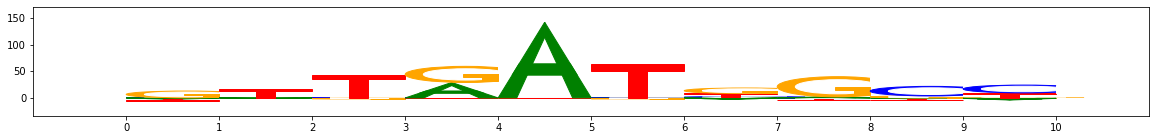

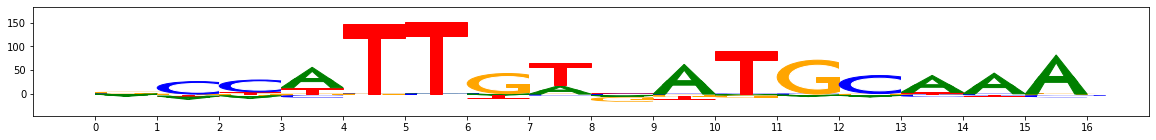

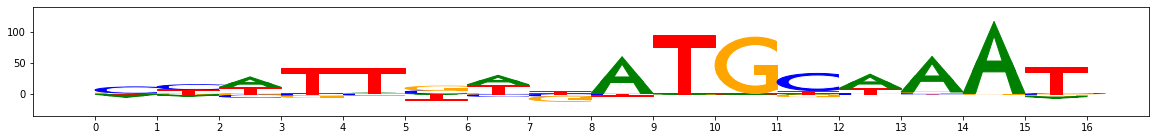

In [40]:
noprior_motifs = import_tfmodisco_motifs(noprior_tfm_path, plot_all_motifs=False, plot_passed_motifs=True)

1257
1192
968
887
Final motifs: 4 total


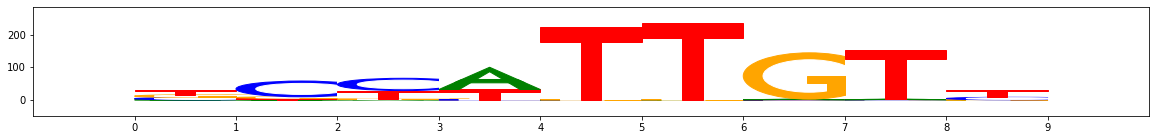

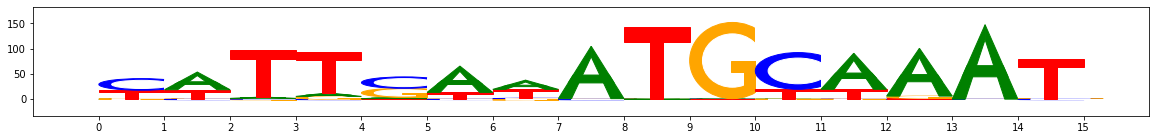

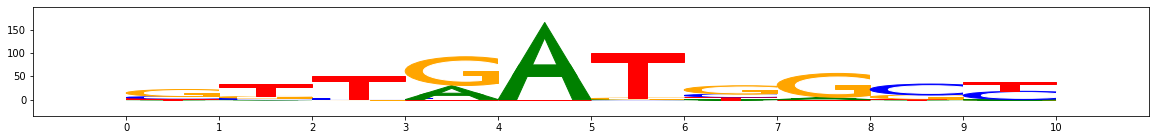

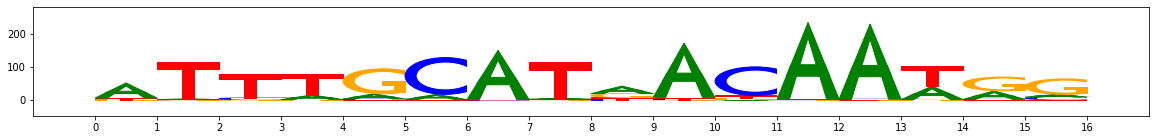

In [41]:
prior_motifs = import_tfmodisco_motifs(prior_tfm_path, plot_all_motifs=False, plot_passed_motifs=True)

### Call motif instances

In [42]:
def jaccard_sim(seq_1, seq_2, normalize=True):
    """
    Takes two windows (W x 4 arrays) and computes a similarity between them,
    using a continuous Jaccard metric. If `normalize` is True, L1 normalizes
    both sequences first.
    """
    if normalize:
        seq_1 = seq_1 / np.sum(np.abs(seq_1))
        seq_2 = seq_2 / np.sum(np.abs(seq_2))
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2)
    union = np.maximum(ab_1, ab_2)
    cont_jaccard = np.sum(inter, axis=1) / np.sum(union, axis=1)
    return np.sum(cont_jaccard)

In [43]:
def call_motifs(coords, imp_scores, cwms, top_contrib_frac=0.01):
    """
    From an N x 3 object array of coordinates and parallel N x I x 4 array
    of actual importance scores, this calls motifs based on Jaccard similarity.
    For each motif CWM in `cwms`, scans to find the best instances. Returns
    the result of all scans (over all motifs together) as an M x 3 object array
    of instance coordinates, a parallel M-array of match scores, and an M-array
    of CWM source indices, all in reverse order by match score.
    """
    assert len(coords) == len(imp_scores)
    assert np.all(coords[:, 2] - coords[:, 1] == input_length), \
        "Expect all coordinates to be of length %d" % input_length
    assert imp_scores.shape[1] == input_length, \
        "Expect important scores to have sequence length %d" % input_length
    
    # Allocate arrays
    array_len = 0
    for cwm in cwms:
        num_windows_per_coord = input_length - len(cwm) + 1
        array_len += num_windows_per_coord * len(coords)
    motif_coords = np.empty((array_len, 3), dtype=object)
    motif_scores = np.empty(array_len)
    cwm_sources = np.empty(array_len, dtype=int)
    contrib_scores = np.empty(array_len)
    
    next_index = 0
    # For each coordinate, for each CWM, for each window, compute the match
    for i in tqdm.notebook.trange(len(coords)):
        chrom, start, end = coords[i]
        imp_score_track = imp_scores[i]
            
        for cwm_i, cwm in enumerate(cwms):
            motif_len = len(cwm)
            rc_cwm = revcomp_motif(cwm)
            num_windows_per_coord = input_length - motif_len + 1

            for j in range(num_windows_per_coord):
                motif_coords[next_index, 0] = chrom
                motif_coords[next_index, 1] = start + j
                motif_coords[next_index, 2] = start + j + motif_len
                imp_score_window = imp_score_track[j:(j + motif_len)]
                motif_scores[next_index] = max(
                    jaccard_sim(imp_score_window, cwm), jaccard_sim(imp_score_window, rc_cwm)
                )
                cwm_sources[next_index] = cwm_i
                contrib_scores[next_index] = np.sum(np.abs(imp_score_window))
                next_index += 1

    # For each CWM, keep only the top few based on contribution score
    mask = np.zeros(len(cwm_sources), dtype=bool)
    for cwm_i in range(len(cwms)):
        cwm_mask = cwm_sources == cwm_i
        cwm_contrib_scores = contrib_scores[cwm_mask]
        limit = np.flip(np.sort(cwm_contrib_scores))[int(len(cwm_contrib_scores) * top_contrib_frac)]
        mask = mask | (cwm_mask & (contrib_scores >= limit))  # Update mask for wherever it is this CWM and score in top %ile
    
    motif_coords = motif_coords[mask]
    motif_scores = motif_scores[mask]
    cwm_sources = cwm_sources[mask]
    
    # Now order by motif match score
    inds = np.flip(np.argsort(motif_scores))
    return motif_coords[inds], motif_scores[inds], cwm_sources[inds]

In [44]:
noprior_motif_coords, noprior_motif_scores, noprior_motif_cwms = call_motifs(
    sample_coords, (noprior_imp_scores * sample_input_seqs), noprior_motifs
)
prior_motif_coords, prior_motif_scores, prior_motif_cwms = call_motifs(
    sample_coords, (prior_imp_scores * sample_input_seqs), prior_motifs
)

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


### Quantify agreement of motif instances with footprints using ranks

In [45]:
noprior_motif_overlap_mask = compute_footprint_overlap(
    noprior_motif_coords[:10000], footprints
)
prior_motif_overlap_mask = compute_footprint_overlap(
    prior_motif_coords[:10000], footprints
)

In [46]:
noprior_motif_overlap_cdf = normed_rank_enrichment(noprior_motif_overlap_mask)
prior_motif_overlap_cdf = normed_rank_enrichment(prior_motif_overlap_mask)

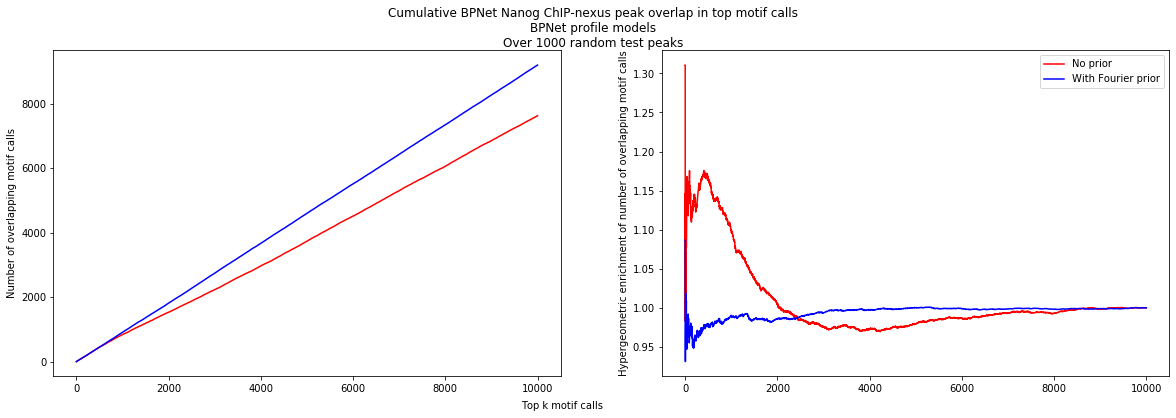

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
if condition_name == "BPNet":
    title = "Cumulative BPNet %s ChIP-nexus peak overlap in top motif calls" % (bpnet_tasks[task_index])
else:
    title = "Cumulative %s footprint overlap in top motif calls" % condition_name
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
fig.suptitle(title)
ax[0].plot(np.cumsum(noprior_motif_overlap_mask), label="No prior", color="red")
ax[0].plot(np.cumsum(prior_motif_overlap_mask), label="With Fourier prior", color="blue")
ax[0].set_ylabel("Number of overlapping motif calls")
ax[1].plot(noprior_motif_overlap_cdf, label="No prior", color="red")
ax[1].plot(prior_motif_overlap_cdf, label="With Fourier prior", color="blue")
ax[1].set_ylabel("Hypergeometric enrichment of number of overlapping motif calls")
fig.text(0.45, 0.05, "Top k motif calls")
plt.legend()

### Correlate motif instances with profile height
This can't be done if there are no ChIP-nexus profiles

In [48]:
noprior_motif_prof_heights = get_interval_profile_heights(noprior_motif_coords[:1000], get_profiles)
prior_motif_prof_heights = get_interval_profile_heights(prior_motif_coords[:1000], get_profiles)

In [49]:
print("Correlation of top motif calls with profile height")
noprior_motif_prof_height_corr = scipy.stats.spearmanr(noprior_motif_scores[:1000], noprior_motif_prof_heights)[0]
prior_motif_prof_height_corr = scipy.stats.spearmanr(prior_motif_scores[:1000], prior_motif_prof_heights)[0]
print("No priors: %f" % noprior_motif_prof_height_corr)
print("With priors: %f" % prior_motif_prof_height_corr)

Correlation of top motif calls with profile height
No priors: 0.057336
With priors: -0.030580


### Quantify agreement of motif instances with profile-derived footprints using ranks
Instead of using pre-determined footprints, we use profile heights to binarize footprint classification

In [50]:
noprior_motif_profoverlap_mask = binarize_footprints_by_profiles(
    noprior_motif_coords[:10000], get_profiles
)
prior_motif_profoverlap_mask = binarize_footprints_by_profiles(
    prior_motif_coords[:10000], get_profiles
)

In [51]:
noprior_motif_profoverlap_cdf = normed_rank_enrichment(noprior_motif_profoverlap_mask)
prior_motif_profoverlap_cdf = normed_rank_enrichment(prior_motif_profoverlap_mask)

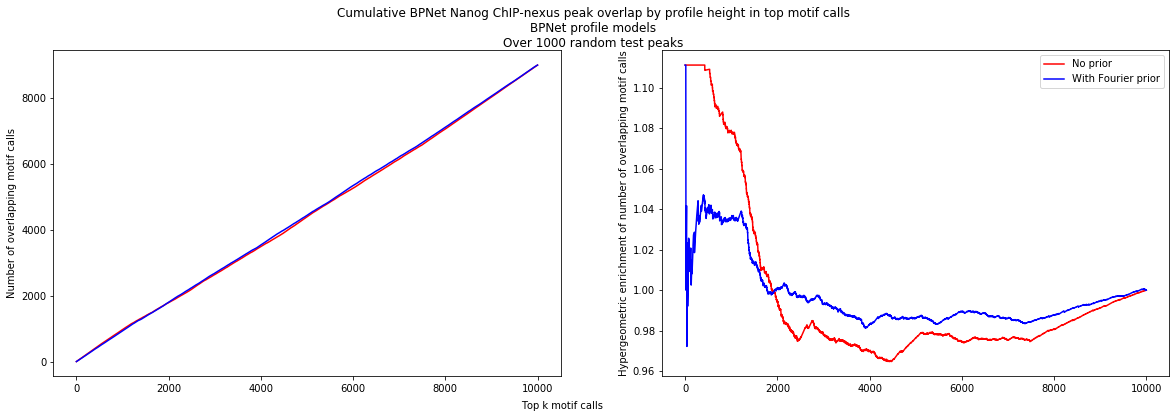

In [52]:
assert condition_name == "BPNet"
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
title = "Cumulative BPNet %s ChIP-nexus peak overlap by profile height in top motif calls" % (bpnet_tasks[task_index])
title += "\n%s %s models" % (condition_name, model_type)
title += "\nOver %d random test peaks" % len(sample)
fig.suptitle(title)
ax[0].plot(np.cumsum(noprior_motif_profoverlap_mask), label="No prior", color="red")
ax[0].plot(np.cumsum(prior_motif_profoverlap_mask), label="With Fourier prior", color="blue")
ax[0].set_ylabel("Number of overlapping motif calls")
ax[1].plot(noprior_motif_profoverlap_cdf, label="No prior", color="red")
ax[1].plot(prior_motif_profoverlap_cdf, label="With Fourier prior", color="blue")
ax[1].set_ylabel("Hypergeometric enrichment of number of overlapping motif calls")
fig.text(0.45, 0.05, "Top k motif calls")
plt.legend()